In [2]:
!pip install memory_profiler

In [3]:
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/70/58/2f94976df39470fb00eec2cb4f914dde44cd0df8d96483208bf7db4bc97e/xgboost-2.1.3-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB 320.0 kB/s eta 0:06:31
   ---------------------------------------- 0.0/124.9 MB 326.8 kB/s eta 0:06:23
   ---------------------------------------- 0.1/124.9 MB 409.6 kB/s eta 0:05:05
   ---------------------------------------- 0.1/124.9 MB 476.3 kB/s eta 0:04:23
   ---------------------------------------- 0.1/124.9 MB 504.4 kB/s eta 0:04:08
   ---------------------------------------- 0.2/124.9 MB 692.9 kB/s eta 0:03:00
   ---------------------------------------- 0.2/124.9 MB 719.7 kB/s eta 0:02:54
   ---------------------------------------- 0.3/124.9 MB 791.9 kB/s eta 0:02:38
   ----------

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, accuracy_score, roc_curve, auc, precision_recall_curve
# from imblearn.over_sampling import SMOTE
# import seaborn as sns
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# from scipy.stats import randint, uniform
# import time
# from memory_profiler import memory_usage

In [7]:
#-----------------------------------------
# 1. Load Data
#-----------------------------------------
train_data = pd.read_parquet('./data/train_scaled.parquet')
test_data = pd.read_parquet('./data/test_scaled.parquet')

In [8]:
#-----------------------------------------
# 2. Train/Test Split
#-----------------------------------------
# Separate features and target
X_train = train_data.drop(['class'], axis=1, errors='ignore') 
y_train = train_data['class']

In [9]:
# Separate features and target
X_test = test_data.drop(['class'], axis=1, errors='ignore') 
y_test = test_data['class']

In [8]:
# 3. Handle Class Imbalance (SMOTE as example)
#-----------------------------------------
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [9]:
#-----------------------------------------
# 4. Define Models
#-----------------------------------------
models = {
    "LogisticRegression": LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42),
    "RandomForest": RandomForestClassifier(n_jobs=-1, random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=1, random_state=42)
}

In [10]:
# Parameter grids for GridSearchCV
param_grids_grid = {
    "LogisticRegression": {
        'C': [0.1, 1, 10],
        'penalty': ['l1', 'l2']
    },
    "RandomForest": {
        'n_estimators': [100, 300, 500],
        'max_depth': [5, 10, 20]
    },
    "XGBoost": {
        'n_estimators': [100, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    }
}

In [11]:
# Parameter distributions for RandomizedSearchCV
param_grids_random = {
    "LogisticRegression": {
        'C': uniform(0.01, 10),
        'penalty': ['l1', 'l2']
    },
    "RandomForest": {
        'n_estimators': randint(100, 501),
        'max_depth': randint(3, 21)
    },
    "XGBoost": {
        'n_estimators': randint(50, 501),
        'max_depth': randint(3, 10),
        'learning_rate': uniform(0.01, 0.3)
    }
}

In [12]:
def tune_model(model, param_grid, X, y, method='grid', scoring='f1', cv=3, n_iter=10):
    """
    Tune the model using either GridSearchCV or RandomizedSearchCV.
    Parameters:
        model: estimator to tune
        param_grid: parameters (grid or distributions) for tuning
        X, y: training data
        method: 'grid' or 'random'
        scoring: metric to optimize (e.g., 'f1', 'accuracy')
        cv: cross-validation folds
        n_iter: for RandomizedSearchCV, number of parameter settings sampled
    """
    if method == 'grid':
        search = GridSearchCV(model, param_grid, scoring=scoring, cv=cv, n_jobs=-1)
    else:  # RandomizedSearchCV
        search = RandomizedSearchCV(model, param_grid, scoring=scoring, cv=cv, n_jobs=-1, n_iter=n_iter, random_state=42)
    
    search.fit(X, y)
    return search.best_estimator_, search.best_params_

In [ ]:
# 5. Hyperparameter Tuning
#-----------------------------------------
best_models = {}
search_method = 'grid'

for model_name, model in models.items():
    print(f"Training and tuning {model_name} using {search_method.capitalize()} SearchCV...")
    if search_method == 'grid':
        best_model, best_params = tune_model(model, param_grids_grid[model_name], X_train_res, y_train_res, method='grid', scoring='f1', cv=3)
    else:
        best_model, best_params = tune_model(model, param_grids_random[model_name], X_train_res, y_train_res, method='random', scoring='f1', cv=3, n_iter=20)
    best_models[model_name] = best_model
    print(f"Best params for {model_name}: {best_params}\n")

Training and tuning LogisticRegression using Grid SearchCV...


In [ ]:
# 6. Evaluate Each Model with Runtime Profiling for Fitting and Prediction
#-----------------------------------------
model_performance = []

for model_name, model in best_models.items():
    print(f"Evaluating {model_name}...")

    # Measure training time
    start_fit = time.time()
    model.fit(X_train_res, y_train_res)  # Refit model for fair timing
    end_fit = time.time()
    fit_time = end_fit - start_fit

    # Measure prediction time
    start_predict = time.time()
    y_pred = model.predict(X_test)
    end_predict = time.time()
    predict_time = end_predict - start_predict

    # Metrics
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    model_performance.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Training Time (s)": fit_time,
        "Prediction Time (s)": predict_time
    })

    print(f"{model_name} - Training Time: {fit_time:.4f} s, Prediction Time: {predict_time:.4f} s")
    print("----------------------------------------------------\n")

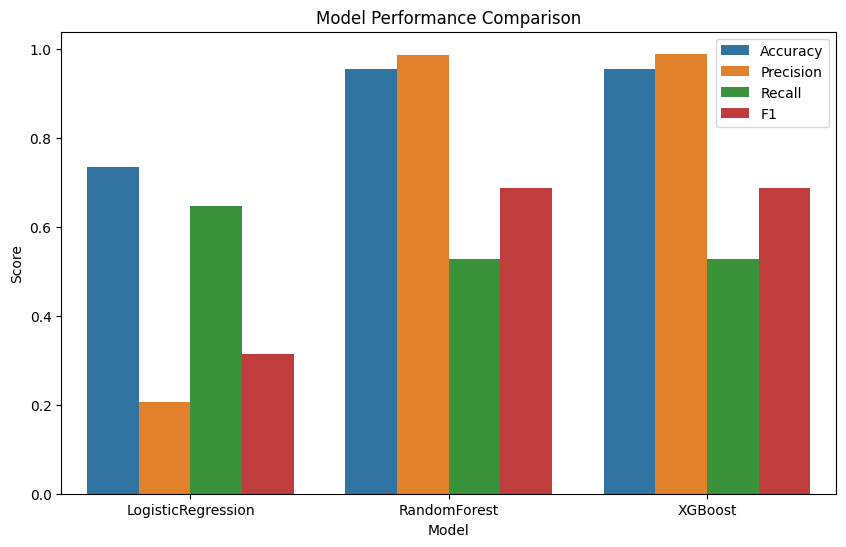

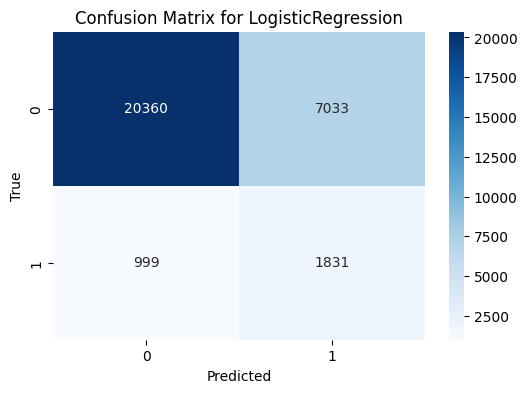

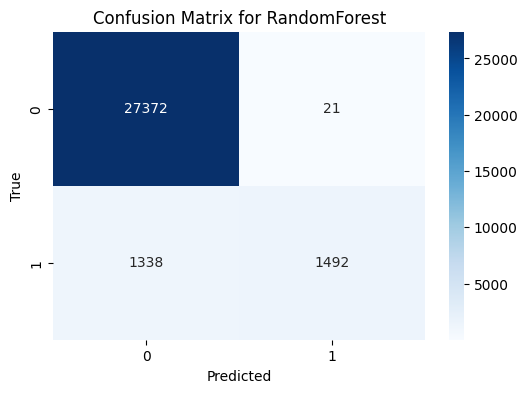

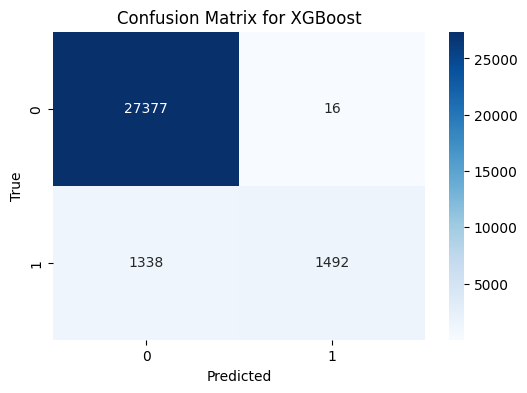

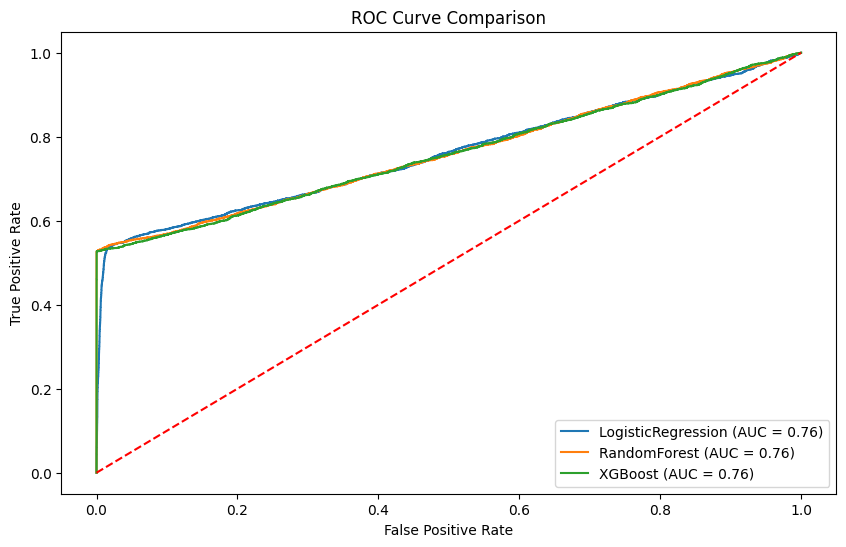

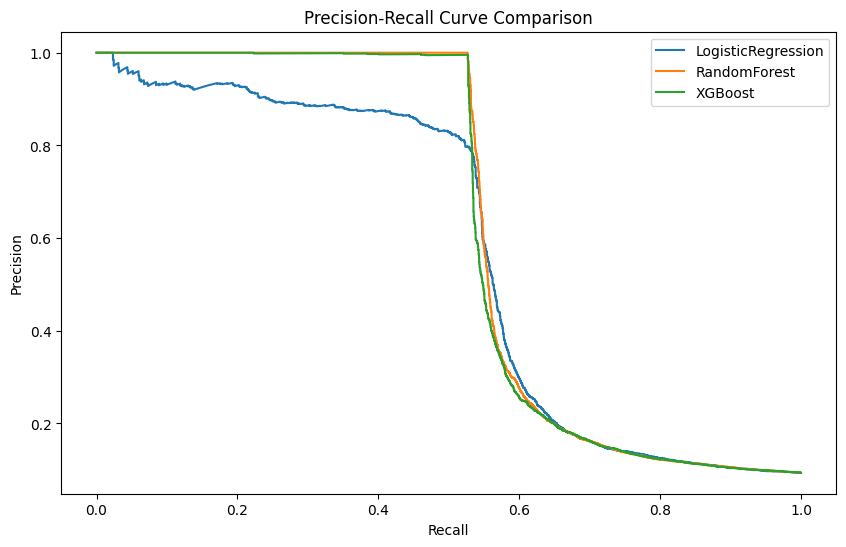

Best Model based on F1-score is: XGBoost with F1-score: 0.6878745965882895
Accuracy for best model: 0.9551996823611157


In [15]:
#-----------------------------------------
# 7. Visualize Metrics and Runtime
#-----------------------------------------
# Convert model performance to DataFrame
df_performance = pd.DataFrame(model_performance)

# Sort by F1-Score for ranking
df_performance = df_performance.sort_values(by='F1-Score', ascending=False)

# Display performance
print(df_performance)

# Visualization of metrics
df_performance_melt = df_performance.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=df_performance_melt[df_performance_melt['Metric'].isin(['Accuracy', 'F1-Score'])],
            x='Model', y='Score', hue='Metric')
plt.title("Model Performance Metrics")
plt.xticks(rotation=45)
plt.show()

# Training and Prediction Time Comparison
time_metrics = df_performance.melt(id_vars='Model', value_vars=['Training Time (s)', 'Prediction Time (s)'], 
                                    var_name='Metric', value_name='Time (s)')

plt.figure(figsize=(8, 4))
sns.barplot(data=time_metrics, x='Model', y='Time (s)', hue='Metric')
plt.title("Training and Prediction Time Comparison")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Confusion matrices for each model
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
# ROC Curves
plt.figure(figsize=(10,6))
for model_name, model in best_models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
    else:
        # For models that do not have predict_proba, use decision_function if available
        if hasattr(model, "decision_function"):
            y_proba = model.decision_function(X_test)
        else:
            # As a fallback, consider predictions as probabilities (not ideal)
            y_proba = model.predict(X_test) 
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'r--')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Precision-Recall Curves
plt.figure(figsize=(10,6))
for model_name, model in best_models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
    else:
        # fallback as above
        if hasattr(model, "decision_function"):
            y_proba = model.decision_function(X_test)
        else:
            # fallback to binary predictions (less informative)
            y_proba = model.predict(X_test)
    precision_pts, recall_pts, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(recall_pts, precision_pts, label=model_name)
plt.title("Precision-Recall Curve Comparison")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc='best')
plt.show()

In [ ]:
# Determine best model based on F1-score
best_model = max(model_scores, key=lambda x: x[-1])
print("Best Model based on F1-score is:", best_model[0], "with F1-score:", best_model[-1])
print("Accuracy for best model:", best_model[1])

In [ ]:
#-----------------------------------------
# 8. Save Models with Joblib
#-----------------------------------------
for model_name, model in best_models.items():
    model_filename = f'{model_name}_#1_best_model.joblib'
    dump(model, model_filename)
    print(f"Saved {model_name} model to {model_filename}")